<H1>Load Datasets<H1>

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

path = os.getcwd()

pd.set_option('display.max_columns', 200)

bracket_training = pd.read_csv(f"{path}/bracket_training.csv", sep= ",")
bracket_training

,CustomerID,CustomerAreaCode,CustomerPostalCode,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion
0,47028,NaN,36093,32.5622,-86.0994,698.0,MONTGOMERY (SELMA),2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694
1,3511,616.0,49464,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164
2,58445,703.0,22210,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559
3,28833,NaN,78218,29.4969,-98.4032,641.0,SAN ANTONIO,2023-11-16,3384825,2024-03-21 10:28:56 -0400,311,610,490,559,311,490,490
4,37899,NaN,14212,42.8946,-78.8245,514.0,BUFFALO,2022-03-16,2828017,2024-03-20 20:14:52 -0400,37,457,387,169,457,387,457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129997,70315,720.0,80130,39.5414,-104.9218,751.0,DENVER,2023-05-01,3602437,2024-03-21 11:53:31 -0400,311,457,334,694,311,694,311
129998,51130,832.0,77407,29.6625,-95.7272,618.0,HOUSTON,2024-07-17,2260739,2024-03-19 23:06:28 -0400,311,8,288,694,8,288,288
129999,36902,NaN,89503,39.5354,-119.8374,811.0,RENO,2021-02-20,1298238,2024-03-18 16:17:25 -0400,164,457,288,169,164,288,164
130000,57171,205.0,35244,33.3538,-86.8254,630.0,BIRMINGHAM (ANN & TUSC),2019-06-01,681594,2024-03-17 21:14:21 -0400,164,8,334,559,164,559,559


In [2]:

college_info = pd.read_csv(f'{path}/institutions.csv', sep = ',', encoding= 'utf-8')

#college_info['InstitutionID'].nunique()

college_info_id = college_info.set_index('InstitutionID')

college_info_id
# college_info.sort_index( ascending=True)

,InstitutionName,InstitutionNickname,InstitutionAbbreviation,InstitutionCity,InstitutionState,InstitutionPostalCode,InstitutionDMACode,InstitutionDMADescription,InstitutionLatitude,InstitutionLongitude,InstitutionConference,InstitutionEnrollment_Male,InstitutionEnrollment_Female,InstitutionEnrollment_Total,InstitutionNCAAMemberSinceDate,RegularSeasonWins,RegularSeasonLosses,RegularSeasonAverageAttendance,RegularSeasonAverageScore
InstitutionID,,,,,,,,,,,,,,,,,,,
626,San Diego St.,Aztecs,SDSU,San Diego,CA,92182,825,SAN DIEGO,32.77525,-117.07120,Mountain West Conference,11992,16456,28448,09/01/1947,24,10,9832.94,74.59
402,McNeese,Cowboys,MCNEES,Lake Charles,LA,70609,643,LAKE CHARLES,30.17819,-93.21722,Southland Conference,2245,3462,5707,09/01/1965,30,3,3085.58,80.42
648,South Carolina,Gamecocks,SO CAR,Columbia,SC,29208,546,"COLUMBIA, SC",33.99679,-81.02693,Southeastern Conference,11273,14774,26047,09/01/1936,26,7,11865.45,72.03
175,Dayton,Flyers,DAY,Dayton,OH,45469-1230,542,DAYTON,39.73955,-84.17611,Atlantic 10 Conference,4245,3872,8117,09/01/1951,24,8,9187.23,74.74
317,James Madison,Dukes,JMU,Harrisonburg,VA,22807,569,HARRISONBURG,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,North Carolina,Tar Heels,UNC,Chapel Hill,NC,27514,560,RALEIGH - DURHAM (FAYETVLLE),35.91177,-79.05097,Atlantic Coast Conference,8068,12174,20242,09/01/1906,27,7,15767.47,81.47
731,Utah St.,Aggies,UT ST,Logan,UT,84322,770,SALT LAKE CITY,41.74075,-111.81390,Mountain West Conference,7236,8552,15788,09/01/1938,27,6,7027.67,79.79
416,Michigan St.,Spartans,MSU,East Lansing,MI,48824,551,LANSING,42.73212,-84.47611,Big Ten Conference,18557,19905,38462,09/01/1919,19,14,14005.79,73.12


<Axes: xlabel='win_%', ylabel='RegularSeasonAverageAttendance'>

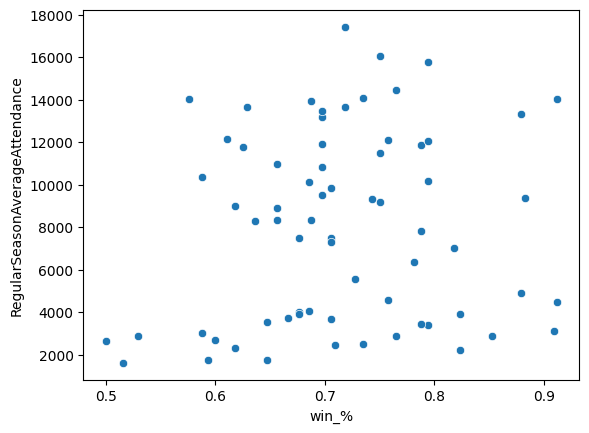

In [3]:

#Slow way to create new columns
# for team in college_info_id['InstitutionName']:
#     college_info_id[f'{team}_win_%'] = college_info_id['RegularSeasonWins']/ (college_info_id['RegularSeasonWins'] + college_info_id['RegularSeasonLosses'])

#Fast way to create new columns
college_info_id['win_%'] = college_info_id['RegularSeasonWins']/ (college_info_id['RegularSeasonWins'] + college_info_id['RegularSeasonLosses'])

#IF college win % isn't causing fans to come to games, will it be the same for customers choosing winners?
sns.scatterplot(x = college_info_id['win_%'], y = college_info_id['RegularSeasonAverageAttendance'])


In [4]:
'''Merge Vs Join'''

# test_df1 = pd.merge(left=bracket_training,
#                     how = "left",
#                     right = college_info_id.add_prefix("EW_"),
#                     left_on = "SemifinalWinner_East_West",
#                     right_index=True,
#                     )

# test_df2 = pd.merge(left= test_df1,
#                     right= college_info_id.add_prefix("SM_"),
#                     how = "left",
#                     left_on = "SemifinalWinner_South_Midwest",
#                     right_index=True
#                     )


test_df = bracket_training.join(
    college_info_id.add_prefix("W_"), on="RegionWinner_West"
).join(
    college_info_id.add_prefix("E_"), on="RegionWinner_East"
).join(
    college_info_id.add_prefix('M_'), on="RegionWinner_Midwest"
).join(
    college_info_id.add_prefix('S_'), on='RegionWinner_South'
)
# print(f'Number of Unique Values: {test_df1['CustomerID'].nunique()}')

test_df


,CustomerID,CustomerAreaCode,CustomerPostalCode,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,CustomerDMADescription,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,W_InstitutionName,W_InstitutionNickname,W_InstitutionAbbreviation,W_InstitutionCity,W_InstitutionState,W_InstitutionPostalCode,W_InstitutionDMACode,W_InstitutionDMADescription,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionConference,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore,W_win_%,E_InstitutionName,E_InstitutionNickname,E_InstitutionAbbreviation,E_InstitutionCity,E_InstitutionState,E_InstitutionPostalCode,E_InstitutionDMACode,E_InstitutionDMADescription,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,E_win_%,M_InstitutionName,M_InstitutionNickname,M_InstitutionAbbreviation,M_InstitutionCity,M_InstitutionState,M_InstitutionPostalCode,M_InstitutionDMACode,M_InstitutionDMADescription,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,M_win_%,S_InstitutionName,S_InstitutionNickname,S_InstitutionAbbreviation,S_InstitutionCity,S_InstitutionState,S_InstitutionPostalCode,S_InstitutionDMACode,S_InstitutionDMADescription,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,S_win_%
0,47028,NaN,36093,32.5622,-86.0994,698.0,MONTGOMERY (SELMA),2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694,Arizona,Wildcats,ZONA,Tucson,AZ,85721,789,TUCSON (SIERRA VISTA),32.23267,-110.95080,Pac-12 Conference,13090,17292,30382,09/01/1936,25,8,12118.18,87.94,0.757576,UConn,Huskies,UCONN,Storrs,CT,06269,533,HARTFORD & NEW HAVEN,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,0.911765,Tennessee,Volunteers,TENN,Knoxville,TN,37996,557,KNOXVILLE,35.95208,-83.92585,Southeastern Conference,15269,18536,33805,09/01/1909,24,8,16065.47,79.47,0.750000,James Madison,Dukes,JMU,Harrisonburg,VA,22807,569,HARRISONBURG,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35,0.911765
1,3511,616.0,49464,42.8256,-86.0104,563.0,GRAND RAPIDS - KALMZOO - B. CRK,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,Baylor,Bears,BAY,Waco,TX,76706,625,WACO - TEMPLE - BRYAN,31.54687,-97.12104,Big 12 Conference,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,0.696970,UConn,Huskies,UCONN,Storrs,CT,06269,533,HARTFORD & NEW HAVEN,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,0.911765,Kansas,Jayhawks,KANSAS,Lawrence,KS,66045,616,KANSAS CITY,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,0.687500,Kentucky,Wildcats,UK,Lexington,KY,40506,541,LEXINGTON,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,0.718750
2,58445,703.0,22210,38.8808,-77.1129,511.0,"WASHINGTON, DC (HAGRSTWN)",2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,Baylor,Bears,BAY,Waco,TX,76706,625,WACO - TEMPLE - BRYAN,31.

In [ ]:
'''Deleting Unwanted Columns'''

# print(test_df.columns)

classic1_df = test_df[
    [
        'CustomerID',
        #'CustomerAreaCode', 'CustomerPostalCode',
       'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude',
       'CustomerDMACode',
        #'CustomerDMADescription',
       'NCAACustomerRecordCreated', 'BracketEntryId',
       'BracketEntryCreatedDate', 'RegionWinner_East', 'RegionWinner_West',
       'RegionWinner_South', 'RegionWinner_Midwest',
       'SemifinalWinner_East_West', 'SemifinalWinner_South_Midwest',
       'NationalChampion',
       'E_InstitutionName',
        # 'E_InstitutionNickname',
        #'E_InstitutionAbbreviation', 'E_InstitutionCity',
        #'E_InstitutionState', 'E_InstitutionPostalCode',
       'E_InstitutionDMACode',
        # 'E_InstitutionDMADescription',
       'E_InstitutionLatitude', 'E_InstitutionLongitude',
       'E_InstitutionConference', 'E_InstitutionEnrollment_Male',
       'E_InstitutionEnrollment_Female', 'E_InstitutionEnrollment_Total',
       'E_InstitutionNCAAMemberSinceDate', 'E_RegularSeasonWins',
       'E_RegularSeasonLosses', 'E_RegularSeasonAverageAttendance',
       'E_RegularSeasonAverageScore',
       'M_InstitutionName',
        # 'M_InstitutionNickname',
        #'M_InstitutionAbbreviation', 'M_InstitutionCity',
        #'M_InstitutionState', 'M_InstitutionPostalCode',
       'M_InstitutionDMACode',
        # 'M_InstitutionDMADescription',
       'M_InstitutionLatitude', 'M_InstitutionLongitude',
       'M_InstitutionConference', 'M_InstitutionEnrollment_Male',
       'M_InstitutionEnrollment_Female', 'M_InstitutionEnrollment_Total',
       'M_InstitutionNCAAMemberSinceDate', 'M_RegularSeasonWins',
       'M_RegularSeasonLosses', 'M_RegularSeasonAverageAttendance',
       'M_RegularSeasonAverageScore',
       'S_InstitutionName',
        # 'S_InstitutionNickname',
        #'S_InstitutionAbbreviation', 'S_InstitutionCity',
        #'S_InstitutionState', 'S_InstitutionPostalCode',
       'S_InstitutionDMACode',
        # 'S_InstitutionDMADescription',
       'S_InstitutionLatitude', 'S_InstitutionLongitude',
       'S_InstitutionConference', 'S_InstitutionEnrollment_Male',
       'S_InstitutionEnrollment_Female', 'S_InstitutionEnrollment_Total',
       'S_InstitutionNCAAMemberSinceDate', 'S_RegularSeasonWins',
       'S_RegularSeasonLosses', 'S_RegularSeasonAverageAttendance',
       'S_RegularSeasonAverageScore',
       'W_InstitutionName',
        #'W_InstitutionNickname', 'W_InstitutionAbbreviation',
        #'W_InstitutionCity', 'W_InstitutionState', 'W_InstitutionPostalCode',
       'W_InstitutionDMACode',
        #'W_InstitutionDMADescription',
       'W_InstitutionLatitude', 'W_InstitutionLongitude',
        #'W_InstitutionConference',
       'W_InstitutionEnrollment_Male',
       'W_InstitutionEnrollment_Female', 'W_InstitutionEnrollment_Total',
       'W_InstitutionNCAAMemberSinceDate', 'W_RegularSeasonWins',
       'W_RegularSeasonLosses', 'W_RegularSeasonAverageAttendance',
       'W_RegularSeasonAverageScore'
    ]
]

classic1_df

Index(['CustomerID', 'CustomerAreaCode', 'CustomerPostalCode',
       'CustomerPostalCodeLatitude', 'CustomerPostalCodeLongitude',
       'CustomerDMACode', 'CustomerDMADescription',
       'NCAACustomerRecordCreated', 'BracketEntryId',
       'BracketEntryCreatedDate', 'RegionWinner_East', 'RegionWinner_West',
       'RegionWinner_South', 'RegionWinner_Midwest',
       'SemifinalWinner_East_West', 'SemifinalWinner_South_Midwest',
       'NationalChampion', 'W_InstitutionName', 'W_InstitutionNickname',
       'W_InstitutionAbbreviation', 'W_InstitutionCity', 'W_InstitutionState',
       'W_InstitutionPostalCode', 'W_InstitutionDMACode',
       'W_InstitutionDMADescription', 'W_InstitutionLatitude',
       'W_InstitutionLongitude', 'W_InstitutionConference',
       'W_InstitutionEnrollment_Male', 'W_InstitutionEnrollment_Female',
       'W_InstitutionEnrollment_Total', 'W_InstitutionNCAAMemberSinceDate',
       'W_RegularSeasonWins', 'W_RegularSeasonLosses',
       'W_RegularSeasonAvera

,CustomerID,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,E_InstitutionName,E_InstitutionDMACode,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,M_InstitutionName,M_InstitutionDMACode,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,S_InstitutionName,S_InstitutionDMACode,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,W_InstitutionName,W_InstitutionDMACode,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore
0,47028,32.5622,-86.0994,698.0,2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Tennessee,557,35.95208,-83.92585,Southeastern Conference,15269,18536,33805,09/01/1909,24,8,16065.47,79.47,James Madison,569,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35,Arizona,789,32.23267,-110.95080,13090,17292,30382,09/01/1936,25,8,12118.18,87.94
1,3511,42.8256,-86.0104,563.0,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55
2,58445,38.8808,-77.1129,511.0,2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55
3,28833,29.4969,-98.4032,641.0,2023-11-16,3384825,2024-03-21 10:28:56 -0400,311,610,490,559,311,490,490,Iowa St.,679,42.02621,-93.64851,Big 12 Conference,14070,11171,25241,09/01/1908,27,7,12059.44,75.56,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,NC State,560,35.78511,-78.67451,Atlantic Coast Conference,11649,11794,23443,09/01/1941,22,14,12147.11,76.36,Saint Mary's,807,37.84073,-122.10900,859,1090,1949,09/01/1961,26,7,3458.15,74.24
4,37899,42.8946,-78.8245,514.0,2022-03-16,2828017,2024-03-20 20:14:52 -0400,37,457,387,169,457,387,457,Auburn,522,32.59938,-85.48826,Southeastern Conference,12695,12684,25379,09/01/1910,27,7,10182.91,83.32,Creighton,652,41.26536,-95.94781,Big East Conference,1789,2501,4290,09/01/1923,23,9,13651.44,80.53,Marquette,617,43.03903,-87.92796,Big East Conference,3328,4200,7528,09/01/1928,25,9,14084.65,78.29,North Carolina,560,35.91177,-79.05097,8068,12174,20242,09

In [6]:
'''Checking NAs'''

#Since the Nan values surmount to around 0.5% of the sample size, I am choosing to get rid of them
# for column in classic1_df.columns:
#     print(f'{column}: {round(((classic1_df[column].isna().sum())/classic1_df.shape[0]) * 100, 3)}  %Nan Values')

classic1_no_na = classic1_df.dropna(axis = 0)

#As We can see the bracket_entry_id is the Number of rows in the dataset, therefore its the primary key
#Also Important, Unique Values is 76097, meaning there are 76097 unique customers that created brackets in 2024
for column in classic1_df.columns:
    print(f'{column}: {((classic1_df[column].nunique()))}  Unique Values')

CustomerID: 76097  Unique Values
CustomerPostalCodeLatitude: 14083  Unique Values
CustomerPostalCodeLongitude: 14540  Unique Values
CustomerDMACode: 209  Unique Values
NCAACustomerRecordCreated: 3226  Unique Values
BracketEntryId: 130002  Unique Values
BracketEntryCreatedDate: 100468  Unique Values
RegionWinner_East: 16  Unique Values
RegionWinner_West: 16  Unique Values
RegionWinner_South: 16  Unique Values
RegionWinner_Midwest: 16  Unique Values
SemifinalWinner_East_West: 32  Unique Values
SemifinalWinner_South_Midwest: 32  Unique Values
NationalChampion: 64  Unique Values
E_InstitutionName: 16  Unique Values
E_InstitutionDMACode: 14  Unique Values
E_InstitutionLatitude: 16  Unique Values
E_InstitutionLongitude: 16  Unique Values
E_InstitutionConference: 13  Unique Values
E_InstitutionEnrollment_Male: 16  Unique Values
E_InstitutionEnrollment_Female: 16  Unique Values
E_InstitutionEnrollment_Total: 16  Unique Values
E_InstitutionNCAAMemberSinceDate: 13  Unique Values
E_RegularSeasonW

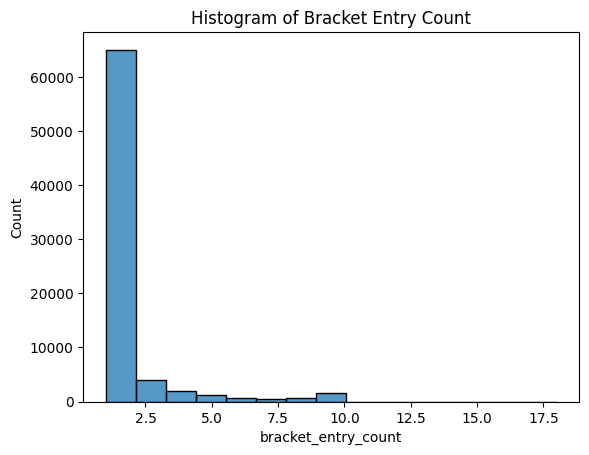

In [7]:
num_brackets_df = classic1_no_na.groupby(by = 'CustomerID').agg(bracket_entry_count= pd.NamedAgg(column = "BracketEntryId", aggfunc = 'count'))

#Way to get agg function to apply to bracket entry id 
# {'BracketEntryId': 'count'}
num_brackets_df[num_brackets_df['bracket_entry_count'] > 1]

# perc_Id_w_multiple_brackets = num_brackets_df[num_brackets_df['BracketEntryId'] > 1].shape[0] / num_brackets_df.shape[0]

# print(perc_Id_w_multiple_brackets)

#We can see that the majority of customers have bracket entries of 1-4
ax = sns.histplot(num_brackets_df['bracket_entry_count'], bins=15)
ax.set_title('Histogram of Bracket Entry Count')
plt.show()




In [8]:
classic2_df = classic1_no_na.join(num_brackets_df,
                               on= 'CustomerID',
                               how = 'left'                         
)

classic2_df

# for column in classic2_df.columns:
#     print(f'{column}: {round(((classic2_df[column].isna().sum())/classic2_df.shape[0]) * 100, 3)}  %Nan Values')

,CustomerID,CustomerPostalCodeLatitude,CustomerPostalCodeLongitude,CustomerDMACode,NCAACustomerRecordCreated,BracketEntryId,BracketEntryCreatedDate,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest,SemifinalWinner_East_West,SemifinalWinner_South_Midwest,NationalChampion,E_InstitutionName,E_InstitutionDMACode,E_InstitutionLatitude,E_InstitutionLongitude,E_InstitutionConference,E_InstitutionEnrollment_Male,E_InstitutionEnrollment_Female,E_InstitutionEnrollment_Total,E_InstitutionNCAAMemberSinceDate,E_RegularSeasonWins,E_RegularSeasonLosses,E_RegularSeasonAverageAttendance,E_RegularSeasonAverageScore,M_InstitutionName,M_InstitutionDMACode,M_InstitutionLatitude,M_InstitutionLongitude,M_InstitutionConference,M_InstitutionEnrollment_Male,M_InstitutionEnrollment_Female,M_InstitutionEnrollment_Total,M_InstitutionNCAAMemberSinceDate,M_RegularSeasonWins,M_RegularSeasonLosses,M_RegularSeasonAverageAttendance,M_RegularSeasonAverageScore,S_InstitutionName,S_InstitutionDMACode,S_InstitutionLatitude,S_InstitutionLongitude,S_InstitutionConference,S_InstitutionEnrollment_Male,S_InstitutionEnrollment_Female,S_InstitutionEnrollment_Total,S_InstitutionNCAAMemberSinceDate,S_RegularSeasonWins,S_RegularSeasonLosses,S_RegularSeasonAverageAttendance,S_RegularSeasonAverageScore,W_InstitutionName,W_InstitutionDMACode,W_InstitutionLatitude,W_InstitutionLongitude,W_InstitutionEnrollment_Male,W_InstitutionEnrollment_Female,W_InstitutionEnrollment_Total,W_InstitutionNCAAMemberSinceDate,W_RegularSeasonWins,W_RegularSeasonLosses,W_RegularSeasonAverageAttendance,W_RegularSeasonAverageScore,bracket_entry_count
0,47028,32.5622,-86.0994,698.0,2021-12-25,1723503,2024-03-19 10:27:15 -0400,164,29,317,694,164,694,694,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Tennessee,557,35.95208,-83.92585,Southeastern Conference,15269,18536,33805,09/01/1909,24,8,16065.47,79.47,James Madison,569,38.43631,-78.87048,Sun Belt Conference,8342,12004,20346,09/01/1969,31,3,4471.35,84.35,Arizona,789,32.23267,-110.95080,13090,17292,30382,09/01/1936,25,8,12118.18,87.94,8
1,3511,42.8256,-86.0104,563.0,2021-04-02,963479,2024-03-18 10:16:39 -0400,164,51,334,328,164,334,164,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Kansas,616,38.95855,-95.24757,Big 12 Conference,8859,9845,18704,09/01/1908,22,10,13952.66,75.25,Kentucky,541,38.03891,-84.50475,Southeastern Conference,9596,13127,22723,09/01/1936,23,9,17427.94,89.44,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,1
2,58445,38.8808,-77.1129,511.0,2021-04-02,810038,2024-03-18 00:21:47 -0400,164,51,288,559,164,559,559,UConn,533,41.80910,-72.24995,Big East Conference,10645,11834,22479,09/01/1910,31,3,14017.88,81.47,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,Houston,618,29.72039,-95.34354,Big 12 Conference,18290,19653,37943,09/01/1949,30,4,9347.35,73.03,Baylor,625,31.54687,-97.12104,6008,8877,14885,09/01/1922,23,10,9517.79,80.55,2
3,28833,29.4969,-98.4032,641.0,2023-11-16,3384825,2024-03-21 10:28:56 -0400,311,610,490,559,311,490,490,Iowa St.,679,42.02621,-93.64851,Big 12 Conference,14070,11171,25241,09/01/1908,27,7,12059.44,75.56,Purdue,582,40.42821,-86.91444,Big Ten Conference,21670,16279,37949,09/01/1914,29,4,13329.06,83.39,NC State,560,35.78511,-78.67451,Atlantic Coast Conference,11649,11794,23443,09/01/1941,22,14,12147.11,76.36,Saint Mary's,807,37.84073,-122.10900,859,1090,1949,09/01/1961,26,7,3458.15,74.24,8
4,37899,42.8946,-78.8245,514.0,2022-03-16,2828017,2024-03-20 20:14:52 -0400,37,457,387,169,457,387,457,Auburn,522,32.59938,-85.48826,Southeastern Conference,12695,12684,25379,09/01/1910,27,7,10182.91,83.32,Creighton,652,41.26536,-95.94781,Big East Conference,1789,2501,4290,09/01/1923,23,9,13651.44,80.53,Marquette,617,43.03903,-87.92796,Big East Conference,3328,4200,7528,09/01/1928,25,9,14084.65,78.29,North Carolina,560,35.91177,-

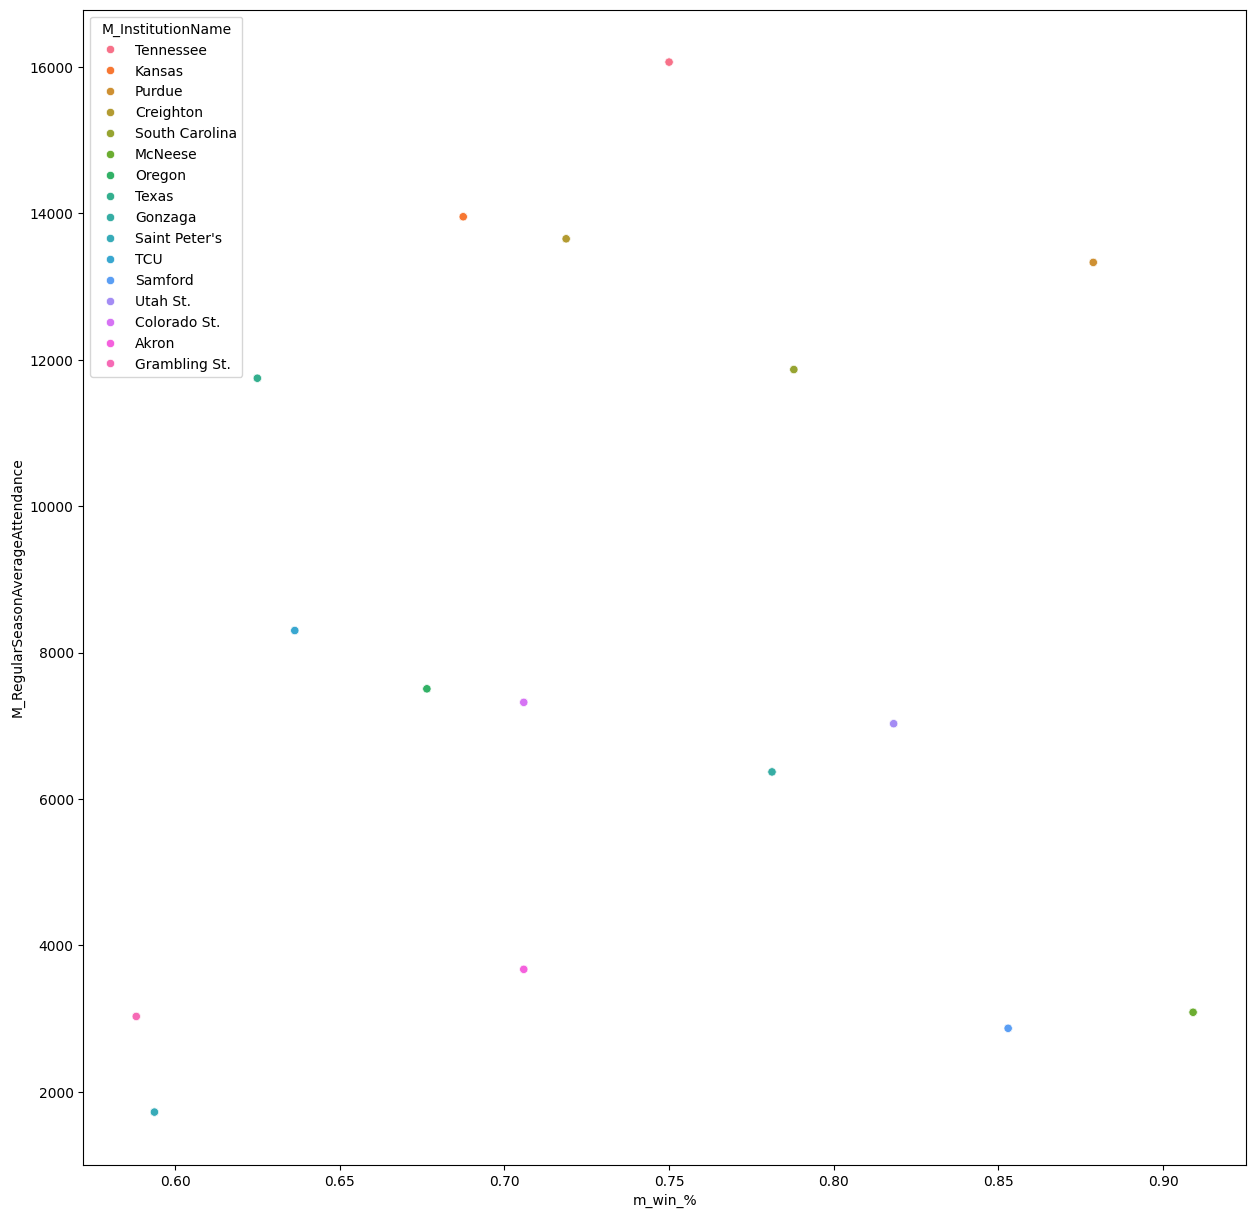

In [10]:
classic2_df['m_win_%'] = classic2_df['M_RegularSeasonWins']/ (classic2_df['M_RegularSeasonWins'] + classic2_df['M_RegularSeasonLosses'])
classic2_df['s_win_%'] = classic2_df['S_RegularSeasonWins']/ (classic2_df['S_RegularSeasonWins'] + classic2_df['S_RegularSeasonLosses'])
classic2_df['e_win_%'] = classic2_df['E_RegularSeasonWins']/ (classic2_df['E_RegularSeasonWins'] + classic2_df['E_RegularSeasonLosses'])
classic2_df['w_win_%'] = classic2_df['W_RegularSeasonWins']/ (classic2_df['W_RegularSeasonWins'] + classic2_df['W_RegularSeasonLosses'])


#Sample graph to show that Customers do not care about How much their team wins!
plt.figure(figsize=(15,15))
ax_attendance = sns.scatterplot(x = classic2_df['m_win_%'], y = classic2_df['M_RegularSeasonAverageAttendance'], hue=classic2_df['M_InstitutionName'])
plt.show()


In [ ]:
# #76097 Customer Ids and It seems that 445 customers created multiple brackets
# #76097 - 75652 = 445

# #We will not be using this transformation any way!
# seq_df = classic2_df.groupby("CustomerID").agg({
#     "RegionWinner_East": lambda x: list(x),
#     "RegionWinner_West": lambda x: list(x),
#     "RegionWinner_South": lambda x: list(x),
#     "RegionWinner_Midwest": lambda x: list(x),
# })
# seq_df

,RegionWinner_East,RegionWinner_West,RegionWinner_South,RegionWinner_Midwest
CustomerID,,,,
1,[301],[457],[796],[169]
2,[164],[457],[334],[559]
4,[164],[610],[334],[169]
5,[311],[29],[288],[169]
6,[164],[29],[387],[559]
...,...,...,...,...
82131,[164],[29],[288],[169]
82132,[164],[457],[334],[648]
82134,"[164, 311]","[29, 457]","[387, 288]","[694, 169]"


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

#Baseline Model -- Choose Team with Higher Winning Percentage

#Create Dataset including information on Midwest Team and South Team

mid_south_basic_df = classic2_df.loc[:, ["RegionWinner_South", 'RegionWinner_Midwest', 'm_win_%','s_win_%', 'SemifinalWinner_South_Midwest']]

X_sm = mid_south_basic_df.drop(columns = ['SemifinalWinner_South_Midwest'])
Y_sm = mid_south_basic_df['SemifinalWinner_South_Midwest']

#Predict that the User will choose the team with higer win %
X_sm['Predicted Winner Binary'] =  (X_sm['m_win_%'] > X_sm['s_win_%']).astype(int)
X_sm['Predicted Winner'] =  np.where(X_sm['Predicted Winner Binary'] == 1, X_sm['RegionWinner_Midwest'], X_sm['RegionWinner_South'])
X_sm['Actual Winner'] = (mid_south_basic_df['SemifinalWinner_South_Midwest'] == X_sm['RegionWinner_Midwest']).astype(int)


recall = recall_score(X_sm['Actual Winner'], X_sm['Predicted Winner Binary'])
accuracy = accuracy_score(X_sm['Actual Winner'], X_sm['Predicted Winner Binary'])

print(f'Baseline Model: Recall {recall}, Accuracy {accuracy}')



east_west_basic_df = classic2_df.loc[:, ["RegionWinner_East", 'RegionWinner_West', 'e_win_%','w_win_%', 'SemifinalWinner_East_West']]

X2_sm = east_west_basic_df.drop(columns = ['SemifinalWinner_East_West'])
Y2_sm = east_west_basic_df['SemifinalWinner_East_West']

#Predict that the User will choose the team with higher win %
X2_sm['Predicted Winner Binary'] =  (X2_sm['e_win_%'] > X2_sm['w_win_%']).astype(int) #IF east wins then 1, else 0
X2_sm['Predicted Winner'] =  np.where(X2_sm['Predicted Winner Binary'] == 1, X2_sm['RegionWinner_East'], X2_sm['RegionWinner_West'])
X2_sm['Actual Winner'] = (east_west_basic_df['SemifinalWinner_East_West'] == X2_sm['RegionWinner_East']).astype(int)


recall2 = recall_score(X2_sm['Actual Winner'], X2_sm['Predicted Winner Binary'])
accuracy2 = accuracy_score(X2_sm['Actual Winner'], X2_sm['Predicted Winner Binary'])

print(f'Baseline Model: Recall {recall2}, Accuracy {accuracy2}')


nat_champ_basic_df = nat_champ_basic_df = pd.DataFrame({
    "ew_pred_win_%": east_west_basic_df["e_win_%"].where(X2_sm["Predicted Winner Binary"] == 1, east_west_basic_df["w_win_%"]),
    "ms_pred_win_%": mid_south_basic_df["m_win_%"].where(X_sm["Predicted Winner Binary"] == 1, mid_south_basic_df["s_win_%"]),
    "actual_nat_champ": classic2_df['NationalChampion']  # Example actual champions
})

# Predict the national champion based on the higher winning percentage
nat_champ_basic_df["predict_nat_champ_binary"] = (
    nat_champ_basic_df["ew_pred_win_%"] > nat_champ_basic_df["ms_pred_win_%"]
).astype(int)

nat_champ_basic_df["actual_nat_champ_binary"] = (nat_champ_basic_df["actual_nat_champ"] == X2_sm["Predicted Winner"]).astype(int) #IF Pred Winner is East West

# Calculate accuracy and recall for national champion prediction
recall_nat_champ = recall_score(nat_champ_basic_df["actual_nat_champ_binary"], nat_champ_basic_df["predict_nat_champ_binary"])
accuracy_nat_champ = accuracy_score(nat_champ_basic_df["actual_nat_champ_binary"], nat_champ_basic_df["predict_nat_champ_binary"])

# Display results
print(f'National Champion Prediction - Baseline Model: Recall {recall_nat_champ:.2f}, Accuracy {accuracy_nat_champ:.2f}')

# X_train, X_test, y_train, y_test = train_test_split(X_sm, Y_sm, test_size=.2, random_state=24)

# log_reg_sm = LogisticRegressionCV(cv=5, scoring='recall', n_jobs=-1, refit=False, random_state=24)
# log_reg_sm.fit(X_train, y_train)


Baseline Model: Recall 0.5000532897541566, Accuracy 0.5993390809045459
Baseline Model: Recall 0.8869589698394046, Accuracy 0.6550760753478725
National Champion Prediction - Baseline Model: Recall 0.83, Accuracy 0.52
